In [1]:
%matplotlib inline

from comet_ml import Experiment

import os
import warnings
import plotutils
import xgboost as xg
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from collections import OrderedDict, namedtuple
from plotly import tools
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

Load features computed for the predetermined sound samples.

In [2]:
path = '/mnt/data/Birdman/samples/features/features_petrels_bp1-8_wl256_th4.csv'
features = pd.read_csv(path, index_col=None)

## Feature selection
The features have been selected based on analysis of their covariance and visual inspection present [here](https://plot.ly/~tracewsl/43)

In [3]:
selected_features = (
    ('petrel', 'presence of storm petrel'),
    ('sound.files', 'name of the file'),
    ('meanfreq', 'mean frequency (in kHz)'),
    ('sd', 'standard deviation of frequency'),
    ('freq.Q75', 'third quantile (in kHz)'),
    ('freq.IQR', 'interquantile range (in kHz)'),
    ('skew', 'skewness - asymmetry of the spectrum'),
    ('kurt', 'kurtosis - peakedness of the spectrum'),
    ('sp.ent', 'spectral entropy'),
    ('sfm', 'spectral flatness'),
    ('meanfun', 'average of fundamental frequency'),
    ('maxfun', 'maximum fundamental frequency'),
    ('meandom', 'average of dominant frequency'),
    ('dfrange', 'range of dominant frequency'),
    ('modindx', 'modulation index'),
    ('meanpeakf', 'mean peak frequency'))

feature_legend = OrderedDict(selected_features)
selected_features_names = [name for name, desc in selected_features]
features = features[selected_features_names]
features = features.fillna(0)

In [4]:
petrel_count = features['petrel'].value_counts()
print(petrel_count)

0    2482
1    1281
Name: petrel, dtype: int64


`1` denotes petrel, `0` lack of thereof (we'll call it *noise* for brevity). There is imbalance in favour of non-petrel features, primarily introduced with three files that in the selected regions represent only noise.

### Subsampling
STHELENA-02_20140605_* contain relatively few samples compared to the:
```
STHELENA-01_20140106_210000_0-15min.wav       840
STHELENA-02_20140108_210100_110-120min.wav    600
STHELENA-01_20140101_210000_55-105min.wav     600
```
For training, we're going to take all sampels from STHELENA-02_20140605_* and subsample the top 3. The data set is already organised such that first 1201 rows from `path` are non-petrels coming from the top 3. We're going to split the dataframe into two: noise-only and mixed.

In [5]:
split_idx = 1200
noise_only_df, df = features.iloc[:split_idx], features.iloc[split_idx:]
petrels = df[df['petrel'] == 1]
nonpetrels = df[df['petrel'] == 0]
print(f'Noise-only count: {len(noise_only_df)}')
print(f'Mixed noise: {len(nonpetrels)}') 
print(f'Mixed petrels: {len(petrels)}') 

Noise-only count: 1200
Mixed noise: 1282
Mixed petrels: 1281


In [7]:
df.head(3)

,petrel,sound.files,meanfreq,sd,freq.Q75,freq.IQR,skew,kurt,sp.ent,sfm,meanfun,maxfun,meandom,dfrange,modindx,meanpeakf
1200,0,STHELENA-01_20140101_210000_55-105min.wav,3.449775,1.749425,4.891,3.015,1.475437,6.202251,0.977536,0.786448,4.855395,5.333333,1.575387,2.9375,20.787234,0.913194
1201,0,STHELENA-02_20140108_210100_110-120min.wav,3.608110,1.829769,5.202,3.314,1.894124,9.501967,0.979052,0.816575,5.333333,5.333333,1.278226,5.1250,6.146341,0.976190
1202,0,STHELENA-02_20140108_210100_110-120min.wav,3.583817,1.826647,5.164,3.267,1.833918,9.445981,0.978609,0.825397,5.333333,5.333333,1.424731,5.0625,11.407407,0.976190


Drop file names and extract target values for training

In [9]:
df = df.drop(['sound.files'], axis=1)
y = df.pop('petrel')
X = df.values

Our data set is balanced, no need to

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
hyperparams = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'gamma': [0.0],
    'max_depth': [3],
    'min_child_weight': [2],
    'subsample': [0.8],
    'reg_alpha': [0.1],
    'reg_lambda': [1]
}

In [24]:
experiment = Experiment(api_key="4PdGdUZmGf6P8QsMa5F2zB4Ui",
                        project_name="general", workspace="tracewsl")

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/tracewsl/general/21d3b5a765f243dfa3bf08adeb7b09d4



In [14]:
experiment.log_multiple_params(hyperparams)

In [15]:
estimator = xg.XGBClassifier(objective='binary:logistic',
                             n_jobs=-1)
clf = model_selection.GridSearchCV(estimator=estimator,
                                   param_grid=hyperparams,
                                   cv=4)

In [16]:
fit_params = clf.fit(X_train, y_train)

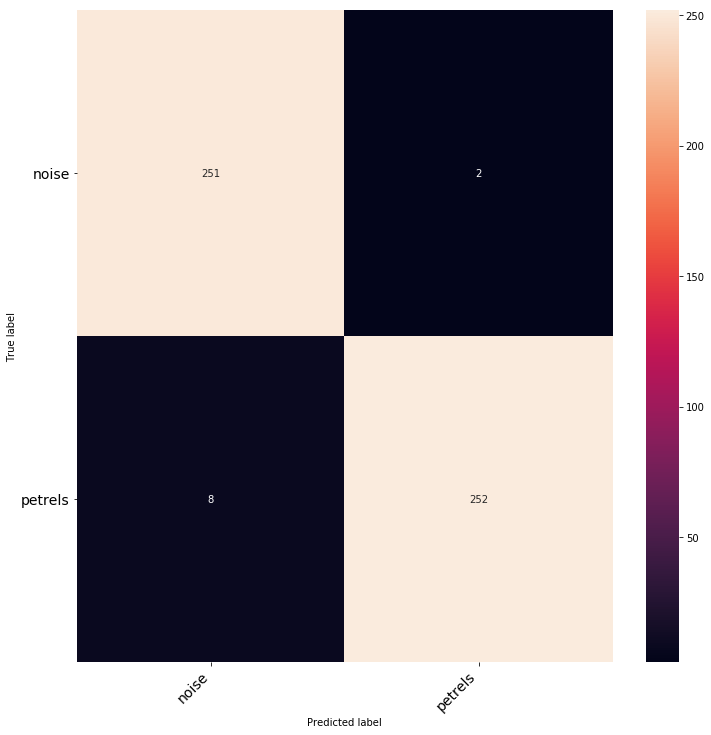

In [17]:
estimator = fit_params.best_estimator_
test_pred = estimator.predict(X_test)

metrics = {
    'accuracy': accuracy_score(y_true=y_test, y_pred=test_pred),
    'precision': precision_score(y_true=y_test, y_pred=test_pred),
    'recall': recall_score(y_true=y_test, y_pred=test_pred),
    'f1-score': f1_score(y_true=y_test, y_pred=test_pred),
}
cm = confusion_matrix(y_true=y_test, y_pred=test_pred)

experiment.log_parameter('name', os.path.basename(path))
experiment.log_multiple_params(fit_params.best_params_)
experiment.log_multiple_metrics(metrics)

cmf_fig = plotutils.print_confusion_matrix(confusion_matrix=cm,
                                           class_names=['noise', 'petrels'],
                                           figsize=(12,12))

experiment.log_figure('Confusion matrix', cmf_fig)

In [18]:
fit_params.best_params_

{'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 100,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'subsample': 0.8}

In [19]:
noise_only_df = noise_only_df.drop(['sound.files'], axis=1)
y_noise = noise_only_df.pop('petrel')
X_noise = noise_only_df.values

In [20]:
test_pred_noise = estimator.predict(X_noise)

In [21]:
test_pred_noise

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
estimator.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.8}

In [ ]:
metrics = {
    'accuracy': accuracy_score(y_true=y_test, y_pred=test_pred),
    'precision': precision_score(y_true=y_test, y_pred=test_pred),
    'recall': recall_score(y_true=y_test, y_pred=test_pred),
    'f1-score': f1_score(y_true=y_test, y_pred=test_pred),
    'cm': confusion_matrix(y_true=y_test, y_pred=test_pred)
}

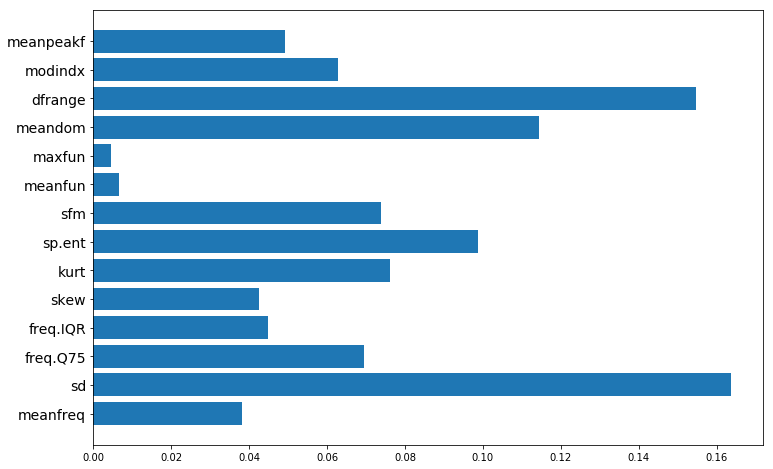

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
names = list(df.columns.values)
y_pos = range(len(names))
plt.barh(y_pos, estimator.feature_importances_)
ax.set_yticks(y_pos)
_ = ax.set_yticklabels(names, fontsize=14)

In [ ]:
joblib.dump(estimator, 'model.pkl')

In [ ]:
x = joblib.load('model.pkl')

In [ ]:
x.feature_importances_

In [ ]:
df.columns.values

In [ ]:
xg.plot_importance(estimator, )

In [26]:
estimator.get_booster().get_fscore()

{'f1': 73,
 'f11': 69,
 'f2': 31,
 'f10': 51,
 'f6': 44,
 'f9': 2,
 'f7': 33,
 'f3': 20,
 'f5': 34,
 'f12': 28,
 'f4': 19,
 'f0': 17,
 'f13': 22,
 'f8': 3}

In [28]:
estimator.feature_importances_

array([0.03811659, 0.16367713, 0.06950673, 0.04484305, 0.0426009 ,
       0.07623319, 0.09865471, 0.07399103, 0.00672646, 0.00448431,
       0.11434978, 0.15470852, 0.06278027, 0.04932735], dtype=float32)

In [ ]:
def get_xgb_imp(xgb, feat_names):
    imp_vals = xgb.get_booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = sum(imp_dict.values())
    return {k:v/total for k,v in imp_dict.items()}

In [ ]:
get_xgb_imp(estimator, list(df.columns.values))

In [ ]:
sum(estimator.get_booster().get_fscore().values())

In [25]:
list(df.columns.values)

['meanfreq',
 'sd',
 'freq.Q75',
 'freq.IQR',
 'skew',
 'kurt',
 'sp.ent',
 'sfm',
 'meanfun',
 'maxfun',
 'meandom',
 'dfrange',
 'modindx',
 'meanpeakf']

In [ ]:
   from numpy import array